In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!rm -rf OptimalRepresentationRL
!git clone https://github.com/AdrienCourtois/OptimalRepresentationRL > /dev/null 2>&1

!git clone https://github.com/rlgammazero/mvarl_hands_on.git > /dev/null 2>&1

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import sys
sys.path.append('./OptimalRepresentationRL')
sys.path.append('./mvarl_hands_on/utils')

from MDPs.toy_small import MDPToySmall
from AVFManager import AVFManager
from MDPs.MDPTwoRoom import MDPTwoRoom
from MDPs.MDPFourRoom import MDPFourRoom
from utils.get_optimal_V import get_optimal_V

from cliffwalk import CliffWalk

import numpy as np
import matplotlib.pyplot as plt
import pickle

# Definition of the MDP

In [0]:
MDP = MDPTwoRoom()

class MDPCliffWalk(CliffWalk):
    def __init__(self):
        super(MDPCliffWalk, self).__init__(proba_succ=0.98)

        self.P = torch.from_numpy(self.P)
        self.r = torch.from_numpy(self.R).mean(2).mean(1)[:,None].float()

        self.n_states = self.P.size(0)
        self.n_actions = self.P.size(1)

        self.is_cuda = False

        self.gamma = 0.8

MDP = MDPCliffWalk()
MDP = MDPFourRoom()

# Calculation of the AVF

In [0]:
#avf_m = AVFManager(MDP)
#avf_m.compute(1000, niter=1000)
#avf_m.save("/content/gdrive/My Drive/Colab Notebooks/models/AVFs1000_1000_4Room.pkl")

avf_m = AVFManager.load("/content/gdrive/My Drive/Colab Notebooks/models/AVFs1000_1000_4Room.pkl")

# Model

In [0]:
 class AVFRepresentation(nn.Module):
    def __init__(self, MDP, d=100):
        super(AVFRepresentation, self).__init__()
        
        self.MDP = MDP
        self.d = d

        self.fc1 = nn.Linear(self.MDP.n_states, 512)
        self.fc2 = nn.Linear(512, self.d)

        self.optimizer = torch.optim.RMSprop(self.parameters(), lr=0.00025)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x
    
    def load(self, path):
        temp = torch.load(path)

        self.fc1.weight.value = temp['fc1.weight']
        self.fc1.bias.value = temp['fc1.bias']

        self.fc2.weight.value = temp['fc2.weight']
        self.fc2.bias.value = temp['fc2.bias']

representation = AVFRepresentation(MDP)
representation.load("/content/gdrive/My Drive/Colab Notebooks/models/Phi_4Room.pth")

# Train

In [0]:
# Hyper parameters
batch_size = 32
n_iter = 200000
d = 100

losses = []

theta = Variable(torch.rand(len(avf_m), d), requires_grad=True)
optim_theta = torch.optim.Adam([theta], lr=1e-5)

# Added
obj_theta = Variable(torch.rand(d), requires_grad=True)
optim_obj_theta = torch.optim.Adam([obj_theta], lr=1e-5)
r = torch.from_numpy(MDP.R).mean(2)

representation = AVFRepresentation(MDP, d=d)

In [0]:
# Precomputation of V_AVF
V_avf = torch.zeros(len(avf_m), MDP.n_states, 1)
for j in range(len(avf_m)):
    V_avf[j] = avf_m.compute_V(avf_m[j])


#######################
for i in range(n_iter):
    # Retrieve batch
    idx = np.random.randint(0, len(avf_m), batch_size)

    # Compute V
    V = V_avf[idx] 
    
    # Compute \hat{V}
    Phi = representation(torch.eye(MDP.n_states)).t()
    V_hat = (Phi.t()[None]*theta[idx][:,None]).sum(2, keepdim=True)
    
    # Computation of the loss
    loss = nn.SmoothL1Loss()(V_hat, V)

    # Added, bellman #
    V_obj = (Phi.t() * obj_theta[None]).sum(1)
    
    Q = r + MDP.gamma * (MDP.P * V_obj[None,None]).sum(2)
    
    V_obj_target = Q.max(1).values.float()

    loss = loss + nn.SmoothL1Loss()(V_obj, V_obj_target)
    ##################

    # Update phi
    loss.backward()
    representation.optimizer.step()
    representation.optimizer.zero_grad()

    # Added, bellman #
    optim_obj_theta.step()
    optim_obj_theta.zero_grad()
    ##################

    # Update theta
    optim_theta.step()
    optim_theta.zero_grad()
    
    if i % 5000 == 0 and i > 0:
        print(i)

    losses.append(loss.item())

plt.plot(np.log(losses))
plt.show()

torch.save(representation.state_dict(), "/content/gdrive/My Drive/Colab Notebooks/models/Phi_4Room.pth")

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000


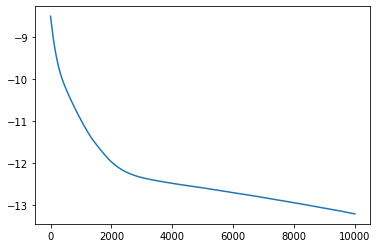

In [57]:
losses_theta = []
optim_obj_theta = torch.optim.Adam([obj_theta], lr=1e-5)

for i in range(10000):
    # Compute \hat{V}
    Phi = representation(torch.eye(MDP.n_states)).t()

    # Added, bellman #
    V_obj = (Phi.t() * obj_theta[None]).sum(1)
    
    Q = r + MDP.gamma * (MDP.P * V_obj[None,None]).sum(2)
    
    V_obj_target = Q.max(1).values.float()

    loss = nn.SmoothL1Loss()(V_obj, V_obj_target)
    ##################

    # Update phi
    loss.backward()
    losses_theta.append(loss.item())

    # Added, bellman #
    optim_obj_theta.step()
    optim_obj_theta.zero_grad()
    ##################

plt.plot(np.log(losses_theta))
plt.show()

# Evaluate

In [58]:
V_true = get_optimal_V(MDP)
V_obj = (Phi.t() * obj_theta[None]).sum(1)

print(torch.norm(V_obj - V_true))

V_obj = (Phi.t() * obj_theta[None]).sum(1)

error, rewards = MDP.evaluate(V_obj)

print(error, np.mean(rewards))

tensor(10.2969, dtype=torch.float64, grad_fn=<NormBackward0>)
103 0.0
